# XGBoost con variables de las diferencias de medias ponderadas

* [Carga de los datos](#carga-de-los-datos)
* [Transformaciones](#transformaciones)
* [Selección de variables](#seleccion-de-variables)
* [Ajuste de hiperparámetros](#ajuste-de-hiperparametros)
* [Conclusiones](#conclusiones)

### Descripción general del notebook

En este notebook se llevará a cabo el modelado y entrenamiento de un modelo XGBoost con el propósito de predecir el ganador de una pelea. Para ello, se utilizarán las diferencias en las estadísticas medias de cada peleador como variables predictoras.

El objetivo principal es explorar alternativas que permitan mejorar el desempeño del modelo en comparación con la versión basada en medias ponderadas.

Dado que el proceso de transformación de datos, selección de variables y ajuste de hiperparámetros será similar al realizado en el otro notebook, estos aspectos no serán abordados en detalle en esta ocasión.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, TimeSeriesSplit,cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
import os
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import mlflow
import optuna
from optuna.samplers import TPESampler
import random

c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(42)
random.seed(42)

In [3]:
ruta_mlflow = os.path.abspath(os.path.join("..", "..", "..", "mlruns"))

 # Configurar MLflow para guardar los modelos en esa ruta
mlflow.set_tracking_uri(f"file:///{ruta_mlflow}")

print("MLflow tracking URI:", mlflow.get_tracking_uri())  

MLflow tracking URI: file:///c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\mlruns


In [4]:
mlflow.set_experiment("Prueba con df ponderado P2 usanod P2_dif XGBoost, datos finales")

2025/03/26 12:50:31 INFO mlflow.tracking.fluent: Experiment with name 'Prueba con df ponderado P2 usanod P2_dif XGBoost, datos finales' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:\\Users\\mattu\\OneDrive\\Documentos\\GitHub\\c2425-R4\\mlruns/703997732876177540', creation_time=1742989831925, experiment_id='703997732876177540', last_update_time=1742989831925, lifecycle_stage='active', name='Prueba con df ponderado P2 usanod P2_dif XGBoost, datos finales', tags={}>

Para guardar los resultados de diferentes experimentos creamos un directorio mlruns donde se guardarán los modelos realizados con una breve descripción y sus resultados.

### Carga de los datos

Cargamos el conjunto de train y test los cuales han sido seleccionados respetando el orden cronológico debido a que es una serie temporal. Separamos los conjuntos en X e y. En X guardamos todas las variables que puedan ser introducidas al modelo, excluyendo los nombres, la fecha y la variable respuesta. En y guardamos la variable respuesta.

In [5]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..","..", "data", "P2_dif","train.parquet")
df_train = pd.read_parquet(ruta_train)
df_train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2010-01-02,Rashad Evans,Thiago Silva,False,0.04,-0.2808,0.193548,-0.40,0.00,-18.84,...,16.0,4,-8.396724,-1,-0.76,0.00,4.00,-0.24,0.0,1.0
1,2010-01-02,Sam Stout,Joe Lauzon,False,0.36,-0.2228,-0.371306,-2.72,0.00,-101.68,...,-3.0,1,-8.453158,-1,-1.60,-2.36,2.36,-1.00,1.0,2.6
2,2010-01-11,Rafael Dos Anjos,Kyle Bradley,False,0.00,0.0416,0.086912,1.52,0.24,213.96,...,0.0,0,-9.999989,0,-0.36,0.00,0.36,-0.60,0.0,0.6
3,2010-01-11,Amir Sadollah,Brad Blackburn,False,-1.84,-0.0176,0.000000,0.44,0.00,23.04,...,-4.0,0,-1.547747,-2,-1.00,1.00,-0.60,0.60,0.0,0.0
4,2010-01-11,Gray Maynard,Nate Diaz,False,0.00,0.0492,0.328320,-0.52,-0.48,249.72,...,-1.0,-1,-2.953928,5,1.00,-4.36,2.96,0.00,0.0,-1.6


In [6]:
ruta_test = os.path.join("..","..","..","data", "P2_dif","test.parquet")
df_test = pd.read_parquet(ruta_test)
df_test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2022-11-19,Kennedy Nzechukwu,Ion Cutelaba,False,-0.4,-0.1032,-0.110729,0.36,0.00,-39.60,...,-1.0,-6,86.483419,1,-0.64,0.00,-1.0,-1.00,-1.96,-1.40
1,2022-11-19,Vince Morales,Miles Johns,True,-0.4,-0.0820,0.153846,0.00,0.36,-52.16,...,0.0,2,14.457185,0,-1.00,0.00,1.0,0.00,-0.36,2.36
2,2022-11-19,Andre Fialho,Muslim Salikhov,True,0.4,0.0696,-0.192661,0.00,0.00,-54.80,...,-4.0,-3,-62.740928,0,-0.40,0.00,-2.6,0.00,-1.00,1.00
3,2022-11-19,Jennifer Maia,Maryna Moroz,False,0.0,-0.1640,-0.069020,-1.08,0.00,-340.04,...,2.0,0,-22.321428,-3,0.00,-0.36,-0.6,0.00,0.00,0.96
4,2022-12-03,Eryk Anders,Kyle Daukaus,False,0.0,-0.1396,-0.158176,-1.68,0.40,189.72,...,-1.0,8,-58.874428,0,3.00,-0.60,2.0,0.64,0.60,2.36


In [7]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_train = df_train["WINNER"]
y_train.value_counts(normalize=True)

WINNER
False    0.56343
True     0.43657
Name: proportion, dtype: float64

In [8]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_test = df_test["WINNER"]
y_test.value_counts(normalize=True)

WINNER
False    0.546166
True     0.453834
Name: proportion, dtype: float64

### Transformaciones

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización. Como no tenemos variables categóricas, tampoco será necesario ningún tipo de codificación.

### Seleccion de variables

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. 

### Ajuste de hiperparametros

Para buscar una configuración óptima de hiperparámetros he utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. 

#### MODELO BASELINE

Creo un modelo simple que debería mejorar tras ajustar los hiperparámetros.

In [ ]:
base = XGBClassifier(random_state=42)
base.fit(X_train,y_train)
#

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [10]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = base.predict(X_test)
y_val_prob = base.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5852895148669797
F1-Score: 0.5047
AUC-ROC: 0.5702
Precisión: 0.5510
Sensibilidad: 0.4655
Log-loss: 0.8943855793762059


El accuracy obtenido es mayor que si predijésemos siempre la clase mayoritaria.

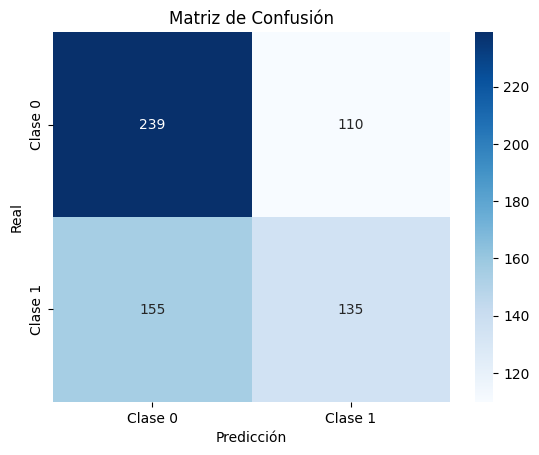

In [11]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

En la matriz de confusión podemos ver que el modelo no obtiene malos resultados cuando gana el favorito. Sin embargo, los resultados no son tan buenos si nos fijamos en la otra clase. Este puede estar producido por el pequeño desbalance de las clases. Trataremos de solucionarlo ajustando los hiperparámetros.

### GridSearch

In [10]:
def train_xgboost_grid(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)


    param_grid = {
    'n_estimators': [100, 250],
    'learning_rate': [0.01, 0.05],  
    'subsample': [0.7, 1.0],  
    'colsample_bytree': [0.5, 0.7, 1.0],  # Añadir 0.5 para más regularización
    'gamma': [0, 0.1],  
    'min_child_weight': [10,35,50],  # Añadir 3 como punto intermedio 
    'reg_alpha': [0.1, 1.0], 
    'reg_lambda': [0.1, 1.0], 
    'scale_pos_weight': [1, scale_pos_weight]  
}


    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return grid_search.best_estimator_,grid_search.best_params_

#### Entrenamiento usando ajuste de hiperparámetros

In [11]:
print("-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --")
best_grid,best_params = train_xgboost_grid(X_train,y_train,X_test,y_test)


-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Mejores parámetros: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 0.1, 'scale_pos_weight': np.float64(1.2905829596412555), 'subsample': 0.7}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.63      0.62      0.63       349
        True       0.56      0.57      0.56       290

    accuracy                           0.60       639
   macro avg       0.60      0.60      0.60       639
weighted avg       0.60      0.60      0.60       639



#### Predicción con el conjunto de test

In [12]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_grid.predict(X_test)
y_val_prob = best_grid.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5978090766823161
F1-Score: 0.5622
AUC-ROC: 0.6145
Precisión: 0.5556
Sensibilidad: 0.5690
Log-loss: 0.6751273207081139


Los resultados obtenidos son mejores que los obtenidos con el modelo base. Esto indica que el ajuste de hiperparámetros es efectivo. El accuracy es cercano al 60%, lo que casi un 6% que predecir siempre la clase mayoritaria.

In [13]:
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="GridSearchCV"):

    # Guardar modelo en MLflow
    mlflow.log_param("mejores_parametros", best_params)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_val_pred))
    mlflow.log_metric("f1_macro", f1_score(y_test, y_val_pred))

    print("Modelo guardado en MLflow")

Modelo guardado en MLflow


Esta celda la utilizamos para guardar el modelo y poder saber cual fue el que mejor nos funcionó cuando los comparemos.

#### Matriz de confusión

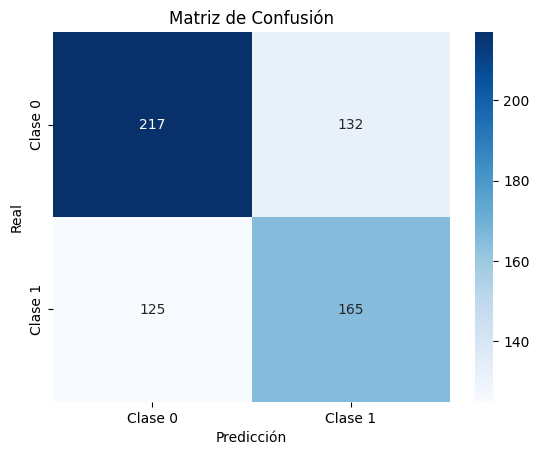

In [14]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Si nos fijamos en la matriz de confusión, hay un gran número de falsos positivos y falsos negativos. Aunque si que predice ambas clases mejor que el modelo baseline.

#### Importancia de cada variable

Se observa que la variable con mayor peso en la predicción es Racha_DIFF, lo que sugiere que la diferencia en las rachas de victorias entre ambos peleadores es un factor determinante al momento de predecir el ganador de la pelea. 

Por otro lado, variables como Puntos_DIFF (diferencia entre los puntos de cada peleador) y Derrotas_Decision_DIFF presentan una importancia similar y considerable.

In [15]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_grid.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                    Feature  Importance
20               Racha_DIFF    0.068097
19              Puntos_DIFF    0.049397
26   Derrotas_Decision_DIFF    0.043937
14        STR_GROUND_A_DIFF    0.043822
24         Derrotas_KO_DIFF    0.041641
18              Peleas_DIFF    0.040595
9           STR_HEAD_A_DIFF    0.039352
4                  REV_DIFF    0.037963
5                 CTRL_DIFF    0.036412
2                   TD_DIFF    0.035998
7          TOTAL_STR_A_DIFF    0.035964
15             STRIKER_DIFF    0.035457
16            GRAPPLER_DIFF    0.035342
3              SUB_ATT_DIFF    0.035179
13        STR_CLINCH_A_DIFF    0.034963
11           STR_LEG_A_DIFF    0.034853
8                 TD_A_DIFF    0.033779
25        Derrotas_Sub_DIFF    0.033431
10          STR_BODY_A_DIFF    0.032885
12      STR_DISTANCE_A_DIFF    0.032566
21        Victorias_KO_DIFF    0.032154
6              TD_PORC_DIFF    0.032033
0                   KD_DIFF    0.031667
1              SIG_STR_DIFF    0.031413


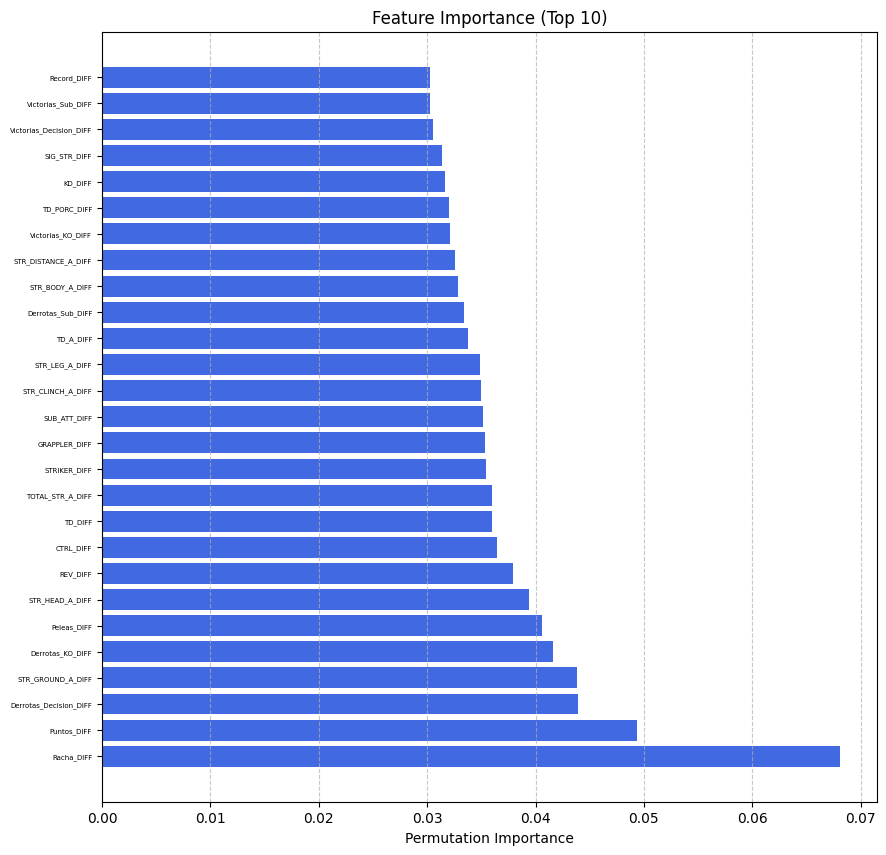

In [16]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

#### Random Search

In [17]:
def train_xgboost_random(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)

    # Distribución de hiperparámetros para búsqueda aleatoria
    """
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 60, 3),
        'learning_rate': np.linspace(0.01, 0.2, 10),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 70, 2),
        'scale_pos_weight': [1, scale_pos_weight]
    }"
    """
    
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 40, 2),
        'learning_rate': np.linspace(0.005, 0.2, 15),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 70, 2),
        'scale_pos_weight': [1, scale_pos_weight],
        'reg_alpha': [0, 0.1, 0.5, 1], #Parámetro regularización
        'tree_method': ['auto', 'exact', 'approx', 'hist'], #Método construcción árbol
        'grow_policy': ['depthwise', 'lossguide'] #Política crecimiento árbol
    }

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')
    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))


    return random_search

#### Entrenamiento usando ajuste de hiperparámetros

In [18]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
resultados_random = train_xgboost_random(X_train,y_train,X_test,y_test)
best_random = resultados_random.best_estimator_
results_cv = resultados_random.cv_results_

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'tree_method': 'exact', 'subsample': np.float64(0.6), 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'n_estimators': np.int64(250), 'min_child_weight': np.int64(9), 'max_depth': np.int64(13), 'learning_rate': np.float64(0.005), 'grow_policy': 'depthwise', 'gamma': np.float64(0.30000000000000004), 'colsample_bytree': np.float64(1.0)}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.62      0.64      0.63       349
        True       0.55      0.53      0.54       290

    accuracy                           0.59       639
   macro avg       0.59      0.59      0.59       639
weighted avg       0.59      0.59      0.59       639



#### Predicción con el conjunto de test

In [19]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_random.predict(X_test)
y_val_prob = best_random.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_test, y_val_pred))

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.593114241001565
F1-Score: 0.5423
AUC-ROC: 0.6084
Precisión: 0.5540
Sensibilidad: 0.5310
Log-loss: 0.6753232395007853
[[225 124]
 [136 154]]


In [20]:
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="RandomizedSearchCV"):

    # Guardar modelo en MLflow
    mlflow.log_param("mejores_parametros", best_params)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_val_pred))
    mlflow.log_metric("f1_macro", f1_score(y_test, y_val_pred))

    print("Modelo guardado en MLflow")

Modelo guardado en MLflow


El modelo obtenido mediante Random Search ha mostrado un rendimiento inferior al modelo ajustado con Grid Search. No obstante, aún sigue siendo mayor que el accuracy del modelo baseline.

#### Matriz de confusión

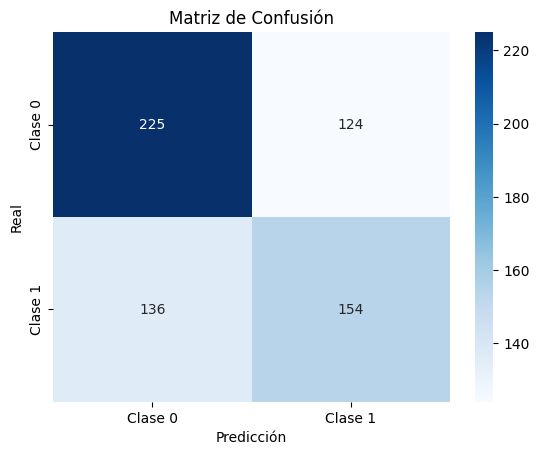

In [21]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Ocurre algo similar al modelo con GridSearh, donde hay un gran número de falsos positivos y negativos. Aunque tiende a predecir algo más la clase 0.

#### Importancia de cada variable

In [22]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_random.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                    Feature  Importance
20               Racha_DIFF    0.063990
19              Puntos_DIFF    0.045405
24         Derrotas_KO_DIFF    0.039783
4                  REV_DIFF    0.039591
18              Peleas_DIFF    0.039157
9           STR_HEAD_A_DIFF    0.038980
26   Derrotas_Decision_DIFF    0.038872
14        STR_GROUND_A_DIFF    0.038680
5                 CTRL_DIFF    0.037453
3              SUB_ATT_DIFF    0.036817
7          TOTAL_STR_A_DIFF    0.036722
2                   TD_DIFF    0.036331
25        Derrotas_Sub_DIFF    0.035709
8                 TD_A_DIFF    0.035542
15             STRIKER_DIFF    0.035401
10          STR_BODY_A_DIFF    0.035358
16            GRAPPLER_DIFF    0.034869
12      STR_DISTANCE_A_DIFF    0.034826
13        STR_CLINCH_A_DIFF    0.034806
11           STR_LEG_A_DIFF    0.034433
21        Victorias_KO_DIFF    0.034414
1              SIG_STR_DIFF    0.034163
0                   KD_DIFF    0.033996
6              TD_PORC_DIFF    0.032400


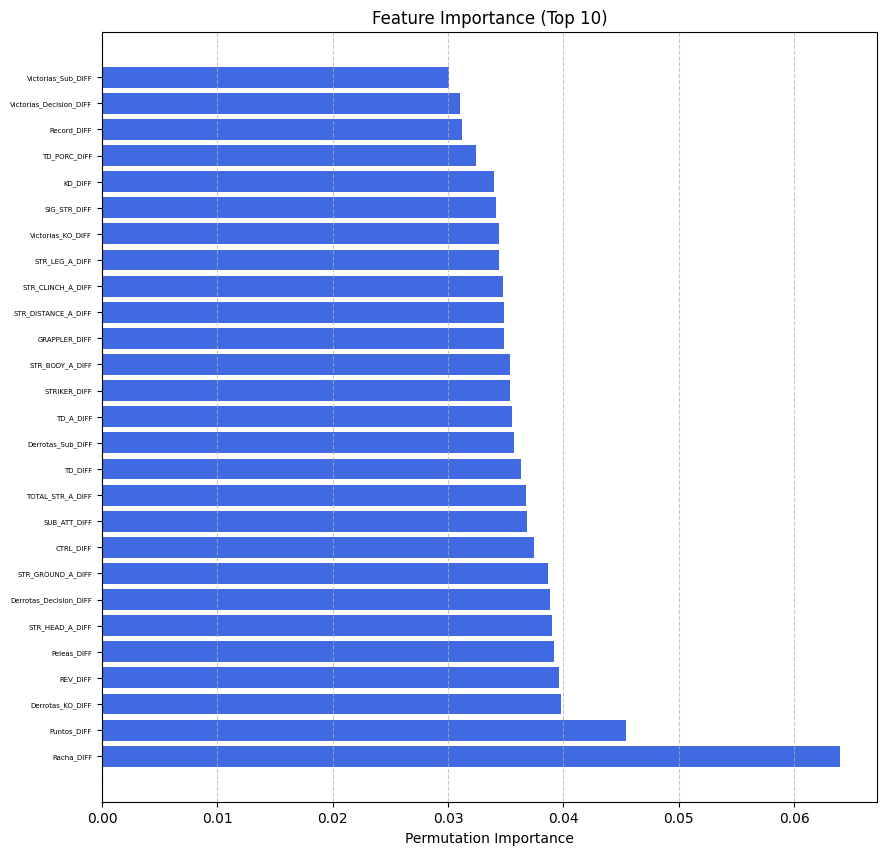

In [23]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

La importancia de las variables es muy similar a la de GridSearch.

#### Optuna
Por último, emplearemos como método de selección de variables Optuna, debido a los buenos resultados entregados en el ajuste de otros modelos.

In [12]:

def objective(trial, X_train, y_train):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1

    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
    'max_depth': trial.suggest_int('max_depth', 3, 49, step=2),  # Ajustado de 40 a 39
    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'gamma': trial.suggest_float('gamma', 0, 1.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 69, step=2),  
    'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, scale_pos_weight]),
    'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.1, 0.5, 1]),
    'tree_method': trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist']),
    'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
    'random_state': 42
}

    # Validación cruzada con series temporales
    tscv = TimeSeriesSplit(n_splits=5)
    model = XGBClassifier(**params)
    optuna.logging.set_verbosity(optuna.logging.INFO)
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='f1_macro', n_jobs=-1)
    return np.mean(scores)  # Retornamos el F1-score promedio


In [15]:
print("-- Entrenamiento usando ajuste de hiperparámetros con Optuna --")
sampler = TPESampler(seed=21)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=10)

best_params = study.best_params
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

[I 2025-03-26 12:51:31,910] A new study created in memory with name: no-name-6214be75-119e-4754-84e4-0b9b322c882c


-- Entrenamiento usando ajuste de hiperparámetros con Optuna --


[I 2025-03-26 12:51:32,373] Trial 0 finished with value: 0.5016071056902714 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.04560003646142163, 'subsample': 0.6086464999663799, 'colsample_bytree': 0.6029613826337195, 'gamma': 0.0507732566953768, 'min_child_weight': 21, 'scale_pos_weight': 1, 'reg_alpha': 0.5, 'tree_method': 'approx', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5016071056902714.
[I 2025-03-26 12:51:33,159] Trial 1 finished with value: 0.48492863578212286 and parameters: {'n_estimators': 250, 'max_depth': 21, 'learning_rate': 0.04379895434381183, 'subsample': 0.7082679090692535, 'colsample_bytree': 0.9270514359956721, 'gamma': 0.9131639696118056, 'min_child_weight': 53, 'scale_pos_weight': 1, 'reg_alpha': 1, 'tree_method': 'approx', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5016071056902714.
[I 2025-03-26 12:51:34,238] Trial 2 finished with value: 0.5012935149608756 and parameters: {'n_estimators': 350, 'max_depth'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9049166524337446, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.3376761198544125,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.013855267540212752,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=39, max_leaves=None,
              min_child_weight=13, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Predicción con el conjunto de test

In [16]:
y_val_pred = best_model.predict(X_test)
y_val_prob = best_model.predict_proba(X_test)[:,1]

print("-- Métricas del modelo con hiperparámetros ajustados --")
print("Accuracy:", accuracy_score(y_test, y_val_pred))
print(f"F1-Score: {f1_score(y_test, y_val_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_val_prob):.4f}")
print(f"Precisión: {precision_score(y_test, y_val_pred):.4f}")
print(f"Sensibilidad: {recall_score(y_test, y_val_pred):.4f}")
print(f"Log-loss: {log_loss(y_test, y_val_prob):.4f}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.6025039123630673
F1-Score: 0.5606
AUC-ROC: 0.6118
Precisión: 0.5625
Sensibilidad: 0.5586
Log-loss: 0.6740


En este caso, el ajuste de hiperparámetros con Optuna da un resultado mejor a los anterior. Llegando al 60% de accuracy.

In [ ]:
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="uso de Optuna para ajustar hiperparámetros n_trials=10, sampler seed=21"):

    # Guardar modelo en MLflow
    mlflow.xgboost.log_model(best_model, "modelo_xgboost")
    mlflow.log_param("mejores_parametros", best_params)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_val_pred))
    mlflow.log_metric("f1_macro", f1_score(y_test, y_val_pred))

    print("Modelo guardado en MLflow")

#### Matriz de confusión

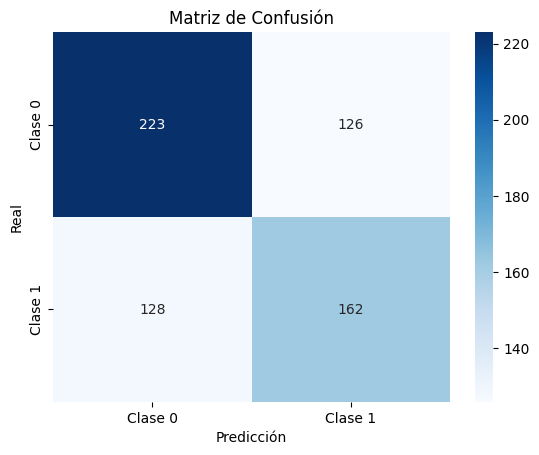

In [17]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

La matriz de confusión es similar a las anteriores, aunque si que predice algo mejor.

#### Importancia de las variables

In [18]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                    Feature  Importance
20               Racha_DIFF    0.070324
19              Puntos_DIFF    0.044228
24         Derrotas_KO_DIFF    0.044183
4                  REV_DIFF    0.040603
14        STR_GROUND_A_DIFF    0.040209
3              SUB_ATT_DIFF    0.039379
18              Peleas_DIFF    0.038949
26   Derrotas_Decision_DIFF    0.038899
2                   TD_DIFF    0.037168
9           STR_HEAD_A_DIFF    0.036884
16            GRAPPLER_DIFF    0.036653
11           STR_LEG_A_DIFF    0.036465
13        STR_CLINCH_A_DIFF    0.035713
21        Victorias_KO_DIFF    0.035208
5                 CTRL_DIFF    0.034932
7          TOTAL_STR_A_DIFF    0.034368
1              SIG_STR_DIFF    0.034088
15             STRIKER_DIFF    0.034076
25        Derrotas_Sub_DIFF    0.033512
8                 TD_A_DIFF    0.033395
10          STR_BODY_A_DIFF    0.033067
23  Victorias_Decision_DIFF    0.032973
0                   KD_DIFF    0.032633
12      STR_DISTANCE_A_DIFF    0.032292


En cuanto a la importancia de las variables también podemos ver que es muy similar a los anteriores. Siendo la racha y los puntos las variables más relevantes.

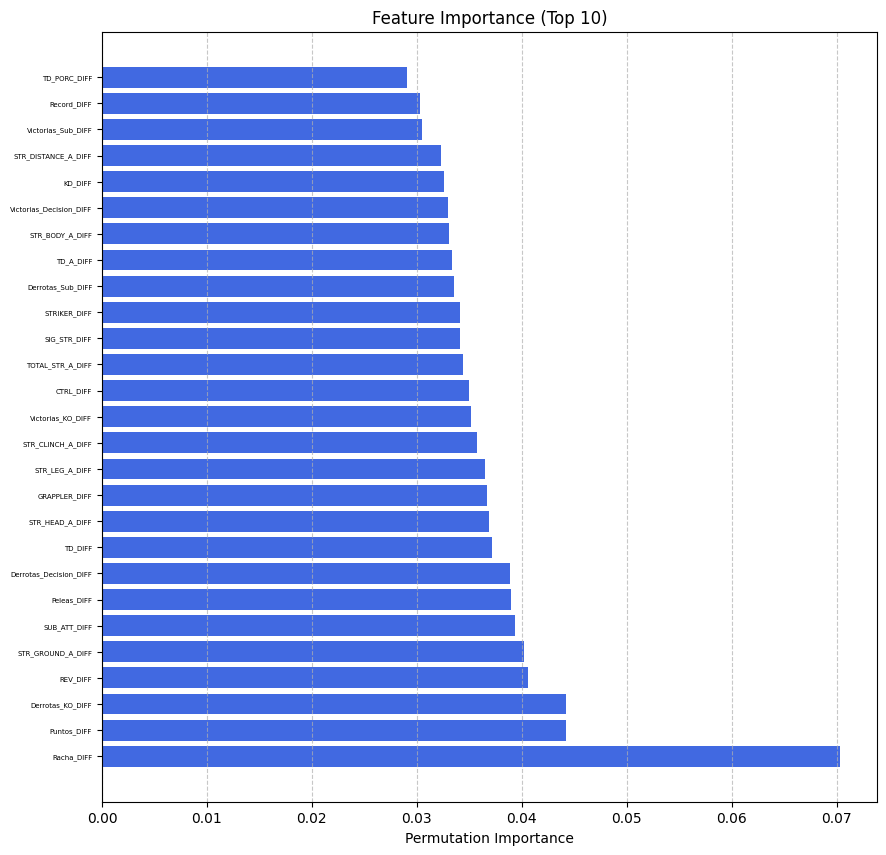

In [19]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

#### Conclusiones
Tras evaluar los resultados del modelo utilizando tres enfoques de ajuste de hiperparámetros, se concluye que el que entrega mejores resultados es el ajustado con Optuna. Siendo algo superior al de GridSearch y RandomSearch.